In [1]:
import cv2
import os
import sys

In [2]:
HOME = os.environ["HOME"]
mickey_path = os.path.join(HOME, "map_free_localization/mickey")
mapfree_path = os.path.join(HOME, "map_free_localization/mapfree")

if os.path.exists(mickey_path):
    sys.path.append(mickey_path)
if os.path.exists(mapfree_path):
    sys.path.append(mapfree_path)



In [ ]:
sift = cv.SIFT_create()
 
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
 
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
 
flann = cv.FlannBasedMatcher(index_params, search_params)
 
matches = flann.knnMatch(des1,des2,k=2)
 
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
 if m.distance < 0.7*n.distance:
 good.append(m)


In [27]:
def find_keypoints(imgs):
    """ Find keypoints for all images in the list, return a list of 
        (keypoint, descriptor) tuples
    """
    sift = cv.SIFT_create()
    return [sift.detectAndCompute(img, None) for img in imgs]

def find_matches(kp1, des1, kp2, des2, min_match_count=10):
    """ Find matches between descriptors """
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    if len(good) > min_match_count:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    return src_pts, dst_pts

    

In [28]:
# Given two images find key points and matches
import numpy as np
import cv2
from matplotlib import pyplot as plt
import glob

def depth_for_image(image_file):
    return os.path.splitext(os.path.split(image_file)[-1:][0])[0] + ".mickey.png"
    
dataset = "val"
seq = "s00460"
data = os.path.join("/media/jprincen/HD", "Map Free Localization")
depth_data = os.path.join(mickey_path, "data/mickey_depths")
data_set = os.path.join(data, dataset)
seq_images = os.path.join(data_set, seq)
seq_query_images = glob.glob(os.path.join(seq_images, "seq1", "*.jpg"))
depth_images = os.path.join(depth_data, dataset, seq, "seq1")
img1_path = seq_query_images[0]
img2_path = seq_query_images[30]
img1 = cv2.imread(img1_path)
fname = depth_for_image(img1_path)
img1_depth = cv2.imread(os.path.join(depth_images, fname), cv2.IMREAD_UNCHANGED)
img2 = cv2.imread(img2_path)
fname = depth_for_image(img2_path)
img2_depth = cv2.imread(os.path.join(depth_images, fname), cv2.IMREAD_UNCHANGED)


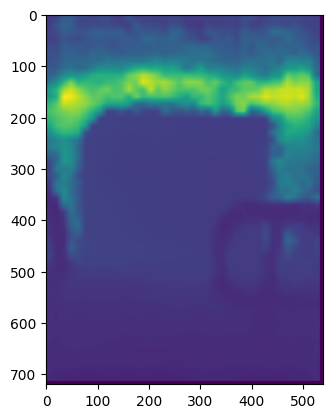

In [29]:
plt.imshow(img1_depth)

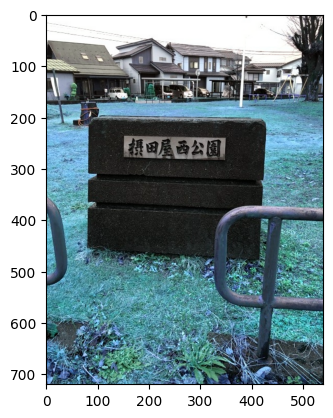

In [30]:
plt.imshow(img1)

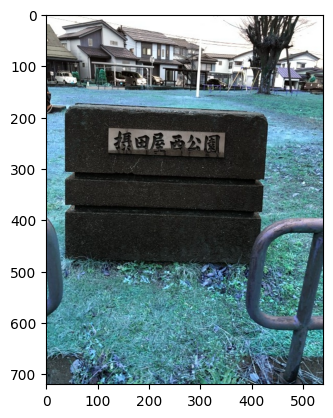

In [31]:
plt.imshow(img2)

In [32]:
kps = find_keypoints([img1, img2])

In [38]:
kp1, des1 = kps[0]
kp2, des2 = kps[1]

In [41]:
des1

array([[  0.,   0.,   0., ...,   8.,   1.,   1.],
       [  2.,  19., 103., ...,   0.,   0.,   0.],
       [  5.,   0.,   0., ...,  32.,   8.,  18.],
       ...,
       [ 96.,  43.,   0., ...,  16.,  50.,  12.],
       [122.,  15.,   5., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,  52.,  19.,   3.]], dtype=float32)

In [42]:
pts1, pts2 = find_matches(kp1, des1, kp2, des2)

In [43]:
len(pts1)

572

In [45]:
MIN_MATCH_COUNT = 10
if len(pts1)>MIN_MATCH_COUNT:
    
    M, mask = cv.findHomography(pts1, pts2, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    
    h,w, _ = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
 
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None


In [46]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
    singlePointColor = None,
    matchesMask = matchesMask, # draw only inliers
    flags = 2)
 
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
 
plt.imshow(img3),plt.show()


NameError: name 'good' is not defined